In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *
from analysis import *

import sys
sys.path.append(constants.GRANTHAM_DISTANCE_PATH)

import grantham_distance as gd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from tqdm.notebook import tqdm

In [5]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [30]:
loaded = False

# Load BioBank Components

In [31]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    (biobank_data_no_HLA_alleles, biobank_index,
     med_code_mapping) = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    print("Integrating HLA Data")
    with Timer() as t:
        HLA_alleles = data_tools.load_HLA_data()
        biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Loading Biobank Index and Data from Cache
Elapsed time: 6.1379 seconds
Integrating HLA Data
Elapsed time: 61.7517 seconds


In [32]:
biobank_data = biobank_data.replace("infectious mononucleosis / glandular fever / epstein barr virus (ebv)", "mononucleosis")

biobank_data['illness_dx_age_interpolated_0.29'] = biobank_data["meat_intake_last_age"].values
biobank_data['illness_code_0.29'] = biobank_data["meat_intake_last_age"].apply(lambda s: "vegetarian"
                                                                               if s >= 0 else np.nan)

/var/folders/vy/ng8z35ts71z736pdwsgxy_300000gn/T/ipykernel_90964/3393117312.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  biobank_data['illness_dx_age_interpolated_0.29'] = biobank_data["meat_intake_last_age"].values
/var/folders/vy/ng8z35ts71z736pdwsgxy_300000gn/T/ipykernel_90964/3393117312.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  biobank_data['illness_code_0.29'] = biobank_data["meat_intake_last_age"].apply(lambda s: "vegetarian"


# All illnesses

In [33]:
data = biobank_data.sample(10000) if len(biobank_data) > 10000 else biobank_data

In [34]:
def get_all_unique_values(data, base_feature: str) -> np.ndarray:
    """"""
    assert base_feature in data, f"{base_feature} not in data columns."
    all_illnesses = biobank_data[get_multiple_features_from_base_feature(data, base_feature)].values.ravel()
    return np.unique(all_illnesses[~pd.isnull(all_illnesses)])

In [36]:
ALL_NON_CANCER_ILLNESSES = list(get_all_unique_values(biobank_data, "illness_code"))
ALL_CANCERS = list(get_all_unique_values(biobank_data, "cancer_code"))
ALL_ILLNESSES = ALL_CANCERS + ALL_NON_CANCER_ILLNESSES

def get_value_feature(value: str):
    if value in ALL_NON_CANCER_ILLNESSES:
        return "illness_code"
    if value in ALL_CANCERS:
        return "cancer_code"
    
    raise ValueError(f"{value} is unknown")
        

In [62]:
def get_dx_age_data(data: pd.DataFrame):
    """"""
    data = biobank_data
    base_feature = "cancer_code"

    all_value_data = {}
    features, dx_age_features = [], []
    for base_feature in ["cancer_code", "illness_code"]:
        assert base_feature in data, f"Invalid base_feature: {base_feature}"
        base_feature_dx_age = base_feature.rstrip("_code") + "_dx_age_interpolated"
        assert base_feature_dx_age in data, f"Dx age feature not found in data '{base_feature_dx_age}'"

        dx_age_features += get_multiple_features_from_base_feature(data, base_feature_dx_age)
        features += get_multiple_features_from_base_feature(biobank_data, base_feature)
    
    iterator = tqdm(zip(features, dx_age_features), total=len(features),
                    desc="Remapping dx ages", unit=" Feature")
    for feature, feature_dx_age in iterator:
        for value in biobank_data[feature].unique():
            if isinstance(value, float):
                continue
            if value not in all_value_data:
                all_value_data[value] = np.ones(len(biobank_data)) * -99
            index = biobank_data[feature] == value
            all_value_data[value][index] = biobank_data[feature_dx_age].values[index]
    
    return pd.DataFrame(all_value_data)

In [70]:
cache_path = os.path.join(constants.UK_BIOBANK_CACHE_PATH, "dx_age_data.pkl")
illness_age_raw_data = cache(get_dx_age_data, (biobank_data,), path=cache_path, rewrite=False)

In [210]:
# Add regular
general_features = ["eid", "sex", "birth_year", "zygosity"]

# Add specific fuzzy treatments

data = biobank_data

treatment_data = {}
fuzzy_treatments = ["b12", "d3", "vitamin", ("antidepressant", "citalopram", "venlafaxine")]
for value in tqdm(fuzzy_treatments, desc="Getting fuzzy treatments", unit=" treatment"):
    if isinstance(value, tuple):
        treatment_data[value[0]] = np.zeros(len(data))
        for v in value[1:]:
            treatment_data[value[0]] = treatment_data[value[0]] | get_illness_value(data, v, "treatment_code", fuzzy=True)
    else:
        treatment_data[value] = get_illness_value(data, value, "treatment_code", fuzzy=True)

treatment_data = pd.DataFrame(treatment_data)

specific_variables = {
    "meat_intake_beef": "Never",
    "meat_intake_lamb": "Never",
    "meat_intake_pork": "Never",
    "meat_intake_poultry": "Never",
    "fish_intake_non_oily": "Never",
    "fish_intake_oily": "Never"
}
specific_data = {}
for variable, value in specific_variables.items():
    specific_data[variable + "_" + value.lower()] = data[variable] == value
specific_data = pd.DataFrame(specific_data)
specific_data["fish_intake_never"] = specific_data["fish_intake_oily_never"] & specific_data["fish_intake_non_oily_never"]

specific_data["male"] = data["sex"] == "Male"
specific_data["female"] = data["sex"] != "Male"

Getting fuzzy treatments:   0%|          | 0/4 [00:00<?, ? treatment/s]

In [211]:
illness_age_data = pd.concat([biobank_data[general_features], illness_age_raw_data], axis=1)
illness_age_data = illness_age_data.replace(-99, np.nan)
illness_values_data = pd.concat([biobank_data[general_features], illness_age_raw_data >= 0,
                              treatment_data, specific_data], axis=1)

In [212]:
illness_graph = np.zeros((len(ALL_ILLNESSES), len(ALL_ILLNESSES)))

for i, illness in enumerate(tqdm(ALL_ILLNESSES)):
    illness_values = illness_values_data[illness].values
    for j, associated_illness in enumerate(ALL_ILLNESSES):
        illness_graph[i, j] = np.count_nonzero(illness_values & illness_values_data[associated_illness].values)

  0%|          | 0/526 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [237]:
main_feature = "depression"
associated_features = ["vegetarian", "female", "meat_intake_beef_never", "meat_intake_poultry_never", "meat_intake_lamb_never"]

text = ""
for feature in associated_features:
    text += variable_OR_test(main_feature, feature, data=illness_values_data)
print(text)

vegetarian == True: OR: 1.284 p-value: 2.1e-17 95% CI: 1.23 - 1.35 N: 1,384 ***
female == False: OR: 0.606 p-value: 0.000 95% CI: 0.59 - 0.62 N: 9,516 ***
meat_intake_beef_never == True: OR: 1.283 p-value: 6.9e-41 95% CI: 1.25 - 1.32 N: 3,772 ***
meat_intake_poultry_never == True: OR: 1.288 p-value: 6.4e-22 95% CI: 1.23 - 1.34 N: 1,771 ***
meat_intake_lamb_never == True: OR: 1.312 p-value: 1.6e-69 95% CI: 1.28 - 1.35 N: 6,014 ***



In [238]:
import statsmodels.api as sm

In [239]:
X = illness_values_data[associated_features] * 1
X["_constant"] = 1
y = illness_values_data[main_feature] * 1

In [240]:
from scipy import stats

In [241]:
logit = sm.Logit(y, X, check_rank=True)
results = logit.fit()
print(results.summary())


CI = 95
z_score = stats.norm.ppf(CI / 100)

results_df = {}
results_df["variables"] = X.columns
results_df["odds_ratios"] = np.exp(results._results.params)
results_df["pvalues"] = results._results.pvalues
results_df["lower_bounds"] = np.exp(results._results.params - results._results.bse * z_score)
results_df["upper_bounds"] = np.exp(results._results.params + results._results.bse * z_score)

results_df = pd.DataFrame(results_df)
results_df = results_df.query("variables != '_constant'")

Optimization terminated successfully.
         Current function value: 0.211839
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             depression   No. Observations:               502536
Model:                          Logit   Df Residuals:                   502530
Method:                           MLE   Df Model:                            5
Date:                Tue, 26 Jul 2022   Pseudo R-squ.:                0.008306
Time:                        22:23:39   Log-Likelihood:            -1.0646e+05
converged:                       True   LL-Null:                   -1.0735e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
vegetarian                   -0.2361      0.061     -3.844      0.000      -0.

In [242]:
results_df

,variables,odds_ratios,pvalues,lower_bounds,upper_bounds
0,vegetarian,0.789706,1.209717e-04,0.713826,0.873652
1,female,1.624017,1.106004e-302,1.589556,1.659225
2,meat_intake_beef_never,1.086148,5.363756e-04,1.044328,1.129642
3,meat_intake_poultry_never,1.187692,1.380517e-03,1.087149,1.297533
4,meat_intake_lamb_never,1.223246,3.315554e-29,1.187633,1.259927


In [244]:
biobank_data["meat_intake_beef"].unique()

array(['Less than once a week', 'Once a week', 'Never',
       '2-4 times a week', 'Prefer not to answer', nan,
       'Once or more daily', 'Do not know', '5-6 times a week'],
      dtype=object)

In [385]:
cancer_codes = [feature for feature in biobank_data.columns if get_base_feature(feature) == "cancer_code"]
all_cancers = biobank_data[cancer_codes].values.ravel()
all_cancers, counts = np.unique(all_cancers[~pd.isnull(all_cancers)], return_counts=True)


cancer_dict = {}
for cancer in tqdm(all_cancers):
    cancer_dict[illness] = get_illness_value(data, illness, "cancer_code")

  0%|          | 0/81 [00:00<?, ?it/s]

In [150]:
illness_data = pd.concat([data[["eid", "sex", "birth_year"]], pd.DataFrame(illness_dict)], axis=1)

In [151]:
illness_graph = np.zeros((len(all_illnesses), len(all_illnesses)))

In [152]:
for i, illness in enumerate(all_illnesses):
    illness_values = illness_data[illness].values
    for j, associated_illness in enumerate(all_illnesses):
        illness_graph[i, j] = np.count_nonzero(illness_values & illness_data[associated_illness].values)

In [153]:
unique_edge_weights = illness_graph[np.triu_indices(len(illness_graph))]
unique_edge_weights = unique_edge_weights[unique_edge_weights != 0]

/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

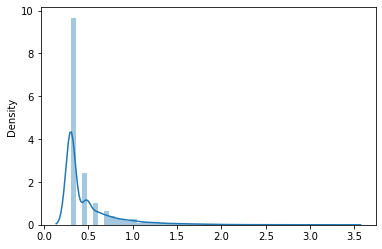

In [154]:
sns.distplot(np.log10(unique_edge_weights + 1))

In [155]:
df = pd.DataFrame(illness_graph, columns=all_illnesses)
df.index = all_illnesses
df

,abdominal hernia,abnormal smear (cervix),acne/acne vulgaris,acromegaly,acute infective polyneuritis/guillain-barre syndrome,adrenal tumour,adrenocortical insufficiency/addison's disease,alcohol dependency,alcoholic liver disease / alcoholic cirrhosis,allergy or anaphylactic reaction to drug,...,vasculitis,vegetarian,venous thromboembolic disease,vertigo,vitiligo,vocal cord polyp,wegners granulmatosis,whooping cough / pertussis,wolff parkinson white / wpw syndrome,yellow fever
abdominal hernia,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abnormal smear (cervix),0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acne/acne vulgaris,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acromegaly,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acute infective polyneuritis/guillain-barre syndrome,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vocal cord polyp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
wegners granulmatosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
whooping cough / pertussis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
wolff parkinson white / wpw syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


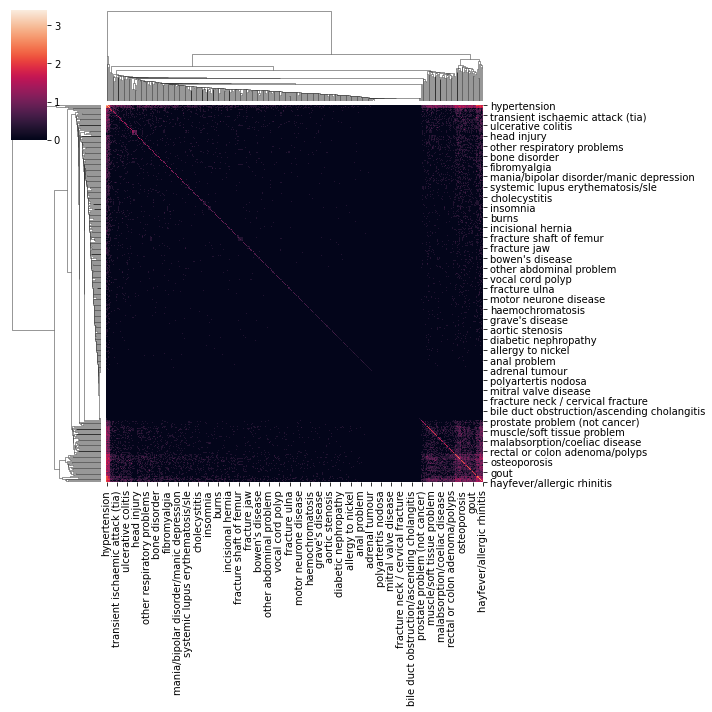

In [156]:
sns.clustermap(np.log10(df + 1))

In [157]:
from analysis import *

In [343]:
data = biobank_data

In [344]:
recieved_B12 = get_illness_value(data, 'b12', "treatment_code", fuzzy=True)
recieved_D3 = get_illness_value(data, 'd3', "treatment_code", fuzzy=True)
recieved_vitamin = get_illness_value(data, 'vitamin', "treatment_code", fuzzy=True)
recieved_antidepressant = get_illness_value(data, 'citalopram', "treatment_code", fuzzy=True)

In [345]:
allergy = get_illness_value(data, 'allergy', "illness_code", fuzzy=True)

R: 0.737  P-value: 0.00864
Mean years before: 9.1
Median years before: 1e+01
vegetarian == True: OR: 1.284 p-value: 2.1e-17 95% CI: 1.23 - 1.35 N: 1,384 ***

depression
recieved B12 == True: OR: 1.579 p-value: 1.3e-08 95% CI: 1.39 - 1.79 N: 192 ***
recieved D3 == True: OR: 1.246 p-value: 8.3e-07 95% CI: 1.16 - 1.34 N: 583 ***
recieved vitamin == True: OR: 1.376 p-value: 1.9e-46 95% CI: 1.33 - 1.43 N: 2,571 ***
recieved D3 or B12 == True: OR: 1.304 p-value: 2e-11 95% CI: 1.22 - 1.39 N: 757 ***
recieved D3 and B12 == True: OR: 2.465 p-value: 0.001 95% CI: 1.63 - 3.73 N: 18 ***
recieved *citalopram == True: OR: 47.145 p-value: 0.000 95% CI: 45.37 - 48.99 N: 6,326 ***


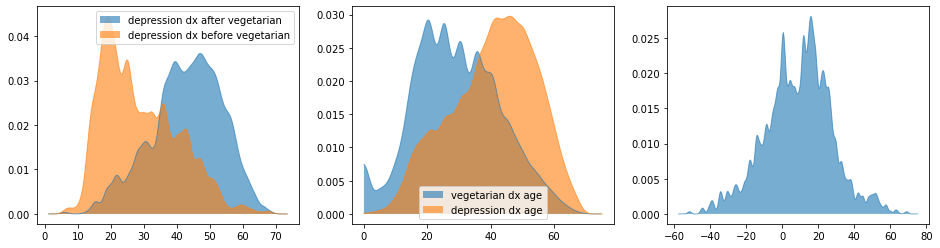

In [346]:
precursor_illness = "vegetarian"
illness = "depression"

_, precursor_dx_ages = get_illness_value_dx_age(data, precursor_illness, "illness_code")
_, illness_dx_ages = get_illness_value_dx_age(data, illness, "illness_code")

precursor_before_illness = illness_dx_ages > precursor_dx_ages
precursor_values, illness_values = precursor_dx_ages >= 0, illness_dx_ages >= 0

fig, (a0, a1, a2) = plt.subplots(figsize=(16, 4), ncols=3)
params = dict(bw=0.1, clip=(0, None))
kde_plot(illness_dx_ages[precursor_values & precursor_before_illness],
         label=f"{illness} dx after {precursor_illness}", ax=a0, **params)
kde_plot(illness_dx_ages[precursor_values & ~precursor_before_illness & illness_values],
         label=f"{illness} dx before {precursor_illness}", ax=a0, **params)
kde_plot(precursor_dx_ages[precursor_values], label=f"{precursor_illness} dx age", ax=a1, **params)
kde_plot(illness_dx_ages[illness_values], label=f"{illness} dx age", ax=a1, **params)
years_before_dx = (illness_dx_ages - precursor_dx_ages)[precursor_values & illness_values]
kde_plot(years_before_dx, bw=.05, ax=a2)

r, p = preceding_event_test(precursor_dx_ages, illness_dx_ages)
if r and p:
    print(f"R: {r:.3}  P-value: {p:.3}")
print(f"Mean years before: {np.mean(years_before_dx):.2}")
print(f"Median years before: {np.median(years_before_dx):.2}")
print(variable_OR_test(illness_values, precursor_values, variable_name=f"{precursor_illness}"))

print(illness)
print(variable_OR_test(illness_values, recieved_B12, variable_name="recieved B12")[:-1])
print(variable_OR_test(illness_values, recieved_D3, variable_name="recieved D3")[:-1])
print(variable_OR_test(illness_values, recieved_vitamin, variable_name="recieved vitamin")[:-1])
print(variable_OR_test(illness_values, recieved_B12 | recieved_D3, variable_name="recieved D3 or B12")[:-1])
print(variable_OR_test(illness_values, recieved_B12 & recieved_D3, variable_name="recieved D3 and B12")[:-1])
print(variable_OR_test(illness_values, recieved_antidepressant, variable_name="recieved *citalopram")[:-1])

In [347]:
no_beef = data["meat_intake_beef"] == "Never"
no_lamb = data["meat_intake_lamb"] == "Never"
no_pork = data["meat_intake_pork"] == "Never"
no_chicken = data["meat_intake_poultry"] == "Never"
no_fish = (data["fish_intake_oily"] == "Never") & (data["fish_intake_non_oily"] == "Never")

no_red_meat = no_lamb & no_beef
no_white_meat = no_pork & no_chicken
no_meat = no_red_meat & no_white_meat
vegetarian = no_meat & no_fish
print(illness)
print(variable_OR_test(illness_values, no_beef, variable_name=f"No beef")[:-1])
print(variable_OR_test(illness_values, no_lamb, variable_name=f"No lamb")[:-1])
print(variable_OR_test(illness_values, no_red_meat, variable_name=f"No Red Meat")[:-1])
print(variable_OR_test(illness_values, no_white_meat, variable_name=f"No White Meat")[:-1])
print(variable_OR_test(illness_values, no_meat, variable_name=f"No Meat")[:-1])
print(variable_OR_test(illness_values, no_fish, variable_name=f"No Fish")[:-1])
print(variable_OR_test(illness_values, vegetarian, variable_name=f"Vegetarian")[:-1])

depression
No beef == True: OR: 1.283 p-value: 6.9e-41 95% CI: 1.25 - 1.32 N: 3,772 ***
No lamb == True: OR: 1.312 p-value: 1.6e-69 95% CI: 1.28 - 1.35 N: 6,014 ***
No Red Meat == True: OR: 1.362 p-value: 8.8e-48 95% CI: 1.32 - 1.41 N: 2,838 ***
No White Meat == True: OR: 1.313 p-value: 5.1e-23 95% CI: 1.26 - 1.37 N: 1,609 ***
No Meat == True: OR: 1.321 p-value: 1.3e-22 95% CI: 1.26 - 1.38 N: 1,511 ***
No Fish == True: OR: 1.357 p-value: 1.3e-24 95% CI: 1.29 - 1.42 N: 1,377 ***
Vegetarian == True: OR: 1.355 p-value: 5.4e-13 95% CI: 1.27 - 1.45 N: 677 ***


In [348]:
_, veg_age_dx = get_illness_value_dx_age(data, "vegetarian", "illness_code")
veg_age_bins = pd.Series(veg_age_dx).apply(lambda s: f"{(s - 10) // 10 * 10} - {s // 10 * 10}")
print(variable_OR_test(illness_values, veg_age_bins, variable_name=f"vegetarian"))

vegetarian != -110.0 - -100.0: OR: 1.284 p-value: 2.1e-17 95% CI: 1.23 - 1.35 N: 1,384 ***
vegetarian == -10.0 - 0.0: OR: 1.050 p-value: 0.633 95% CI: 0.88 - 1.24 N: 99
vegetarian == 0.0 - 10.0: OR: 1.391 p-value: 1.4e-05 95% CI: 1.23 - 1.57 N: 204 ***
vegetarian == 10.0 - 20.0: OR: 1.361 p-value: 3e-08 95% CI: 1.25 - 1.49 N: 385 ***
vegetarian == 20.0 - 30.0: OR: 1.194 p-value: 0.004 95% CI: 1.08 - 1.32 N: 308 ***
vegetarian == 30.0 - 40.0: OR: 1.157 p-value: 0.034 95% CI: 1.04 - 1.29 N: 236 ***
vegetarian == 40.0 - 50.0: OR: 1.477 p-value: 7.4e-05 95% CI: 1.26 - 1.72 N: 123 ***
vegetarian == 50.0 - 60.0: OR: 1.561 p-value: 0.025 95% CI: 1.13 - 2.15 N: 29 ***



# Logistic Regression ORs

In [349]:
from sklearn.linear_model import LogisticRegression as LR

In [350]:
import statsmodels.api as sm

In [351]:
X = [np.ones(len(data)).reshape(-1, 1)]
X.append((data[["sex"]].values == "Female") * 1)
X = np.hstack(X + [precursor_values.reshape(-1, 1) * 1])
y = (illness_values * 1).reshape(-1, 1)

In [352]:
logit = sm.Logit(y, X)
results = logit.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.212038
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               502536
Model:                          Logit   Df Residuals:                   502533
Method:                           MLE   Df Model:                            2
Date:                Sun, 24 Jul 2022   Pseudo R-squ.:                0.007371
Time:                        17:05:44   Log-Likelihood:            -1.0656e+05
converged:                       True   LL-Null:                   -1.0735e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1440      0.011   -299.173      0.000      -3.165      -3.123
x1             0.4957      0.

In [353]:
variable_OR_test(illness_values, precursor_values)

' == True: OR: 1.284 p-value: 2.1e-17 95% CI: 1.23 - 1.35 N: 1,384 ***\n'

In [354]:
print(np.exp(results._results.params))
results._results.pvalues

[0.04310884 1.64169803 1.19404839]


array([0.00000000e+00, 0.00000000e+00, 6.12464038e-10])

In [332]:
vars(results._results)

{'model': <statsmodels.discrete.discrete_model.Logit at 0x29ab85a30>,
 'df_model': 1.0,
 'df_resid': 273400.0,
 '_cache': {'llf': -66979.27365559933,
  'llnull': -66985.99748121358,
  'prsquared': 0.00010037658416794937,
  'llr': 13.447651228489121,
  'llr_pvalue': 0.00024531310761705507,
  'bse': array([0.00789117, 0.0332427 ]),
  'tvalues': array([-335.21208008,    3.7246979 ]),
  'pvalues': array([0.        , 0.00019555]),
  'fittedvalues': array([-2.64521395, -2.64521395, -2.64521395, ..., -2.64521395,
         -2.64521395, -2.64521395])},
 'nobs': 273402,
 'params': array([-2.64521395,  0.123819  ]),
 'k_constant': 1,
 '_data_attr': [],
 '_data_in_cache': ['fittedvalues', 'resid', 'wresid'],
 'normalized_cov_params': array([[ 6.22704904e-05, -6.22704904e-05],
        [-6.22704904e-05,  1.10507691e-03]]),
 'scale': 1.0,
 '_use_t': False,
 'mle_retvals': {'fopt': 0.24498457822400468,
  'iterations': 7,
  'score': array([-8.38026675e-15,  2.95917549e-17]),
  'Hessian': array([[-0.062

In [207]:
np.random.seed(6)
some_illnesses_raw = sorted(np.random.choice(all_illnesses, 20))
some_illnesses_raw = all_illnesses

illness_dx_data = {}
for illness in tqdm(some_illnesses_raw, desc="Aggregating illness dates", unit=" illnesses"):
    new_illness_label = illness.replace(" ", "_")
    _, illness_dx_age = get_illness_value_dx_age(biobank_data, illness, "illness_code")
    illness_dx_data[new_illness_label] = illness_dx_age

illness_dx_data = pd.DataFrame(illness_dx_data)
some_illnesses = list(illness_dx_data.columns)

Aggregating illness dates:   0%|          | 0/445 [00:00<?, ? illnesses/s]

In [212]:
np.random.seed(6)
some_illnesses = sorted(np.random.choice(list(illness_dx_data.columns), 20, replace=False))
# some_illnesses = list(illness_dx_data.columns)
some_illnesses = sorted(set(some_illnesses + ["mononucleosis", "multiple_sclerosis", "vegetarian",
                                              "depression", "anxiety/panic_attacks", "schizophrenia", 
                                              "pernicious_anaemia"]))

In [213]:
some_illnesses

['anxiety/panic_attacks',
 'aortic_regurgitation_/_incompetence',
 'appendicitis',
 'cataract',
 'cerebral_palsy',
 'cranial_nerve_problem/palsy',
 'depression',
 'enlarged_prostate',
 'fracture_toe',
 'gestational_diabetes',
 "housemaid's_knee_(prepatellar_bursitis)",
 'infective/viral_hepatitis',
 'insomnia',
 'lichen_sclerosis',
 'macular_degeneration',
 'mitral_valve_prolapse',
 'mononucleosis',
 'multiple_sclerosis',
 'muscle_or_soft_tissue_injuries',
 'pemphigoid/pemphigus',
 'pernicious_anaemia',
 'retinal_problem',
 'schizophrenia',
 'scleroderma/systemic_sclerosis',
 'vegetarian',
 'wegners_granulmatosis',
 'yellow_fever']

In [214]:
from tqdm.notebook import tqdm

In [216]:
# Precomputing age distributions
params = dict(min_value=-1, max_value=110, n_sample=1000, force_kde=True)

distributions = {}
for illness in tqdm(some_illnesses, unit=" illnesses", desc="Precomputing age distributions"):
    illness_dx_ages = illness_dx_data[illness].values
    illness_values = illness_dx_ages >= 0
    _, y_probs = create_sampled_distribution(illness_dx_ages[illness_values], **params)
    distributions[illness] = (y_probs, illness_values)

preceding_event_values = []

# comparing all illness age distributions
pbar = tqdm(total=len(some_illnesses) ** 2, unit=" illnesses", desc="Identifying preceding illnesses")
for illness in some_illnesses:
    illness_preceding_tests = []
    for precursor_illness in some_illnesses:
        if precursor_illness == illness:
            illness_preceding_tests.append([np.nan, 0, 0, 0])
        else:

            precursor_dx_ages, illness_dx_ages = illness_dx_data[precursor_illness].values, illness_dx_data[illness].values

            illness_dist, illness_values = distributions[illness]
            precursor_dist, precursor_values = distributions[precursor_illness]
            illness_and_infection = precursor_values & illness_values
                
            n_with_illness_and_infection = np.count_nonzero(illness_and_infection)
            precedes = illness_dx_ages > precursor_dx_ages
            n_with_illness_and_prior_infection = np.count_nonzero(illness_and_infection & precedes)
            p = np.sum(np.append([0], np.cumsum(precursor_dist))[:-1] * illness_dist)
            
            frac_with_preceding = n_with_illness_and_prior_infection / np.count_nonzero(illness_dx_ages)

            if n_with_illness_and_infection <= 4:
                illness_preceding_tests.append([np.nan, 0, 0, 0])
            else:
                results = stats.binomtest(n_with_illness_and_prior_infection, n_with_illness_and_infection,
                                          p=p, alternative="greater")
                illness_preceding_tests.append([results.pvalue, n_with_illness_and_prior_infection,
                                            n_with_illness_and_infection, p, frac_with_preceding])

        pbar.update(1)

    preceding_event_values.append(illness_preceding_tests)
pbar.close()

# preceding_tests = pd.DataFrame(preceding_tests, columns=some_illnesses)
# preceding_tests.index = some_illnesses

Precomputing age distributions:   0%|          | 0/27 [00:00<?, ? illnesses/s]

Identifying preceding illnesses:   0%|          | 0/729 [00:00<?, ? illnesses/s]

In [219]:
preceding_event_values

array([[list([nan, 0, 0, 0]), list([nan, 0, 0, 0]),
        list([0.4525549613269867, 71, 80, 0.8752854792719924, 0.00014128341054173233]),
        list([0.05963359022069923, 30, 114, 0.19935061048739278, 5.969721572185873e-05]),
        list([nan, 0, 0, 0]),
        list([0.28083921746718943, 3, 5, 0.378405127488918, 5.9697215721858734e-06]),
        list([1.0, 301, 1840, 0.5145940046626514, 0.000598962064409316]),
        list([0.06049735982845561, 17, 80, 0.14362353928978874, 3.382842224238661e-05]),
        list([0.6995909067887438, 3, 5, 0.6099406804029226, 5.9697215721858734e-06]),
        list([nan, 0, 0, 0]), list([nan, 0, 0, 0]),
        list([0.9606790009686166, 13, 21, 0.7648646572857567, 2.5868793479472117e-05]),
        list([0.9981582803546084, 7, 35, 0.41714728084356834, 1.3929350335100372e-05]),
        list([1.0, 0, 6, 0.22133071385669173, 0.0]),
        list([0.3601785048246342, 2, 7, 0.17733032563823226, 3.979814381457249e-06]),
        list([nan, 0, 0, 0]),
        

In [217]:
preceding_event_values = np.array(preceding_event_values)
data_keys = ["pvalue", "n_with_preceding", "n_with_both", "frac_preceded"]
preceding_events_data = {key: preceding_event_values[:, :, i] for i, key in enumerate(data_keys)}
preceding_events_data["all"] = preceding_event_values
preceding_events_data["columns"] = np.array(some_illnesses)
preceding_events_data["rows"] = np.array(some_illnesses)

p_value_significance_threshold = 0.05

significant_values = preceding_event_values[:, :, 0] <= p_value_significance_threshold
row_index, col_index = np.any(significant_values, axis=1), np.any(significant_values, axis=0)

all_significant_events = preceding_event_values[row_index][:, col_index]
significant_events_data = {key: all_significant_events[:, :, i] for i, key in enumerate(data_keys)}
significant_events_data["all"] = all_significant_events
significant_events_data["columns"] = np.array(some_illnesses)[col_index]
significant_events_data["rows"] = np.array(some_illnesses)[row_index]

/var/folders/vy/ng8z35ts71z736pdwsgxy_300000gn/T/ipykernel_51029/813613934.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preceding_event_values = np.array(preceding_event_values)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [218]:
significant_events_data["pvalue"].shape

(6, 7)

In [131]:
test = preceding_events_data["frac_preceded"]

test[preceding_events_data["pvalue"] > 0.05] = 0

test

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
      

In [123]:
preceding_events_data["frac_preceded"]

array([[0.        , 0.        , 0.87528548, 0.19935061, 0.        ,
        0.37840513, 0.514594  , 0.14362354, 0.60994068, 0.        ,
        0.        , 0.76486466, 0.41714728, 0.22133071, 0.17733033,
        0.        , 0.85633522, 0.57027526, 0.5515343 , 0.        ,
        0.3623798 , 0.74297436, 0.36431208, 0.74119558, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.62936369, 0.29892496, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.78486339, 0.        ,
        0.        ],
       [0.12367685, 0.        , 0.        , 0.05427195, 0.        ,
        0.        , 0.1191036 , 0.01792605, 0.20419027, 0.        ,
        0.        , 0.29906836, 0.09493753, 0.02971072, 0.02767543,
        0.        , 0.41039341, 0.10843592, 0.18988856, 0.        ,
      

# Preceding Event Graph

In [139]:
edge_list

,source,target,type,weight
0,anxiety/panic_attacks,vegetarian,Undirected,0.257075
1,cataract,depression,Undirected,0.183775
2,cataract,fracture_toe,Undirected,0.159062
3,cataract,vegetarian,Undirected,0.081419
4,depression,housemaid's_knee_(prepatellar_bursitis),Undirected,0.500026
5,depression,vegetarian,Undirected,0.261645
6,enlarged_prostate,depression,Undirected,0.124947
7,enlarged_prostate,muscle_or_soft_tissue_injuries,Undirected,0.151422
8,enlarged_prostate,vegetarian,Undirected,0.031752
9,multiple_sclerosis,vegetarian,Undirected,0.269596


In [132]:
G = np.zeros_like(significant_events_data["pvalue"])
edge_list = []

for j, preceding_illness in enumerate(significant_events_data["columns"]):
    for i, illness in enumerate(significant_events_data["rows"]):
        if significant_events_data["pvalue"][i, j] < p_value_significance_threshold:
#             G[i, j] = 1 / (significant_events_data["n_with_preceding"][i, j] / significant_events_data["n_with_both"][i, j])
            G[i, j] = significant_events_data["frac_preceded"][i, j]
#             print(preceding_illness, " -> ",  illness, significant_events_data["all"][i, j])
            edge_list.append([preceding_illness, illness, "Undirected", G[i, j]])
edge_list = pd.DataFrame(edge_list, columns = ["source", "target", "type", "weight"])

In [133]:
import networkx as nx
g = nx.from_pandas_edgelist(edge_list, source="source", target="target", edge_attr="weight")

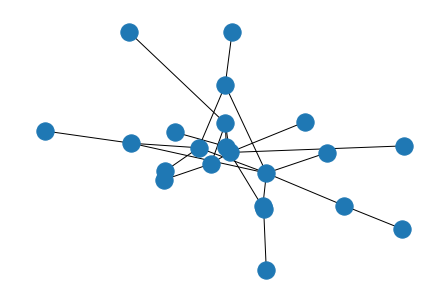

In [134]:
# nx.draw(g, pos=nx.circular_layout(g))
nx.draw(g, pos=nx.draw_kamada_kawai(g),  arrowstyle='fancy')

In [135]:
import pyvis.network as nt
net = nt.Network(notebook=True, directed=True)

net.from_nx(g)
net.show("illness_EDA_plots/example.html")

Text(860.8749999999999, 0.5, 'Illness')

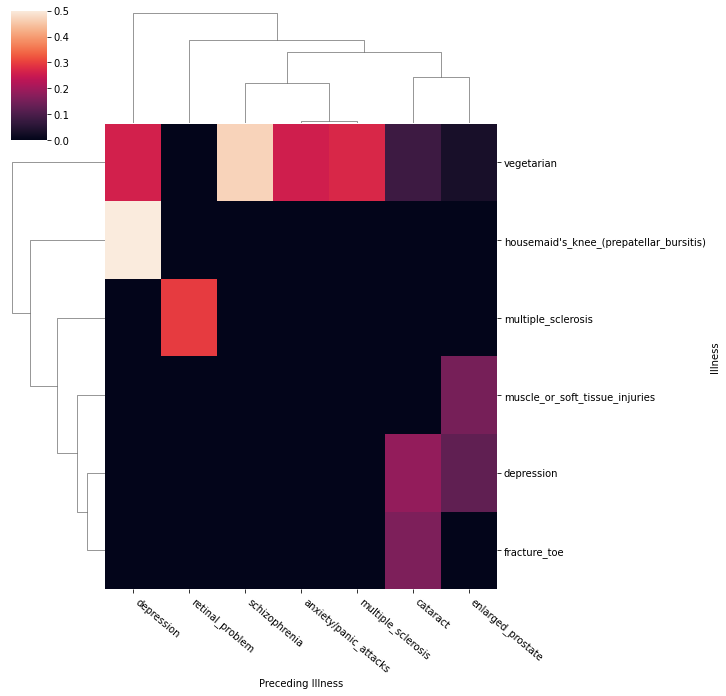

In [138]:
df = pd.DataFrame(G, columns=significant_events_data["columns"])
df.index = significant_events_data["rows"]

g = sns.clustermap(df)
ax = g.ax_heatmap
plt.setp(ax.get_xticklabels(), rotation=320, ha="left")
ax.set_xlabel("Preceding Illness")
ax.set_ylabel("Illness")

In [96]:
p_value_threshold = 0.05
df = pd.DataFrame(preceding_events_data["pvalue"], columns=preceding_events_data["columns"])
df.index = preceding_events_data["rows"]
significant = df.loc[df.lt(p_value_threshold).any(axis=1), df.lt(p_value_threshold).any()]
significant

,anxiety/panic_attacks,cataract,depression,enlarged_prostate,multiple_sclerosis,retinal_problem,schizophrenia
depression,1.000000,0.003279,NaN,8.573562e-08,0.775667,0.417466,1.000000
fracture_toe,0.642189,0.001810,0.073306,NaN,NaN,NaN,NaN
housemaid's_knee_(prepatellar_bursitis),NaN,NaN,0.031258,NaN,NaN,NaN,NaN
multiple_sclerosis,0.971477,0.748026,0.998645,4.955415e-01,NaN,0.028964,NaN
muscle_or_soft_tissue_injuries,0.712770,0.093259,0.948951,9.447599e-03,0.882977,0.439856,0.996220
vegetarian,0.001579,0.019074,0.003025,7.547421e-06,0.017929,0.353301,0.038637


In [97]:
df = pd.read_csv(os.path.join(constants.RESOURCES_DIR_PATH, "cached_data", "all_illness_preceding_tests.csv"))
df.index = df["Unnamed: 0"].values
df = df.drop(["Unnamed: 0"], axis="columns")
df

,abdominal_hernia,abnormal_smear_(cervix),acne/acne_vulgaris,acromegaly,acute_infective_polyneuritis/guillain-barre_syndrome,adrenal_tumour,adrenocortical_insufficiency/addison's_disease,alcohol_dependency,alcoholic_liver_disease_/_alcoholic_cirrhosis,allergy_or_anaphylactic_reaction_to_drug,...,varicose_veins,vasculitis,venous_thromboembolic_disease,vertigo,vitiligo,vocal_cord_polyp,wegners_granulmatosis,whooping_cough_/_pertussis,wolff_parkinson_white_/_wpw_syndrome,yellow_fever
abdominal_hernia,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335652,...,0.096525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abnormal_smear_(cervix),NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400481,...,0.227919,NaN,NaN,0.166417,NaN,NaN,NaN,0.128795,NaN,NaN
acne/acne_vulgaris,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.373692,...,0.426655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acromegaly,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acute_infective_polyneuritis/guillain-barre_syndrome,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vocal_cord_polyp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.562114,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
wegners_granulmatosis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
whooping_cough_/_pertussis,NaN,0.128373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
wolff_parkinson_white_/_wpw_syndrome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [98]:
import time
import numpy as np
np.random.seed(42)
a = np.random.uniform(size=(300, 300))
runtimes = 10

timecosts = []
for _ in range(runtimes):
    s_time = time.time()
    for i in range(100):
        a += 1
        np.linalg.svd(a)
    timecosts.append(time.time() - s_time)

print(f'mean of {runtimes} runs: {np.mean(timecosts):.5f}s')

mean of 10 runs: 2.96316s
